In [242]:
import pandas as pd
import re
import string
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk import sent_tokenize
from pywsd.utils import lemmatize_sentence
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('Restaurant reviews.csv')
reviews = df['Review']

In [3]:

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation + '’'))
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

In [4]:
reviews.dropna(inplace=True)

In [5]:
reviews = reviews.apply(lambda x: sent_tokenize(x))

In [6]:
reviews = reviews.apply(lambda x: [lemmatize_sentence(clean_text(s)) for s in x])

In [9]:
from gensim.models import Word2Vec

reviews_ = []
for i in reviews.values:
    reviews_.append([w for s in i for w in s])


In [10]:
word2vec = Word2Vec(workers=8)

In [11]:
models = []
for sg in [0, 1]:
    for epochs in [5, 10, 15]:
        for vector_size in [20, 30, 40]:
            for window in [1, 2, 3]:
                for min_count in [2, 3, 4]:
                    models.append(
                        Word2Vec(sentences=reviews_, epochs=epochs, vector_size=vector_size, window=window,
                                 min_count=min_count, sg=sg)
                    )


In [ ]:
# from collections import Counter
# Counter([w for r in reviews_ for w in r]).most_common(5)


In [137]:
# for m in models:
#     if m.wv.most_similar('good', 5)[0][1]>0.7:
#         print(m.wv.most_similar('good', 5)[0])

('amazingthe', 0.7029135823249817)
('comfortable', 0.7183482646942139)
('comfortable', 0.7528727650642395)
('comfortable', 0.7067489624023438)


In [24]:
idx, max = 0, -1
for idx_, model in enumerate(models):
    similarities = model.wv.evaluate_word_pairs('wordsim353.tsv')

    if similarities[0].statistic > max:
        idx = idx_
        max = similarities[0].statistic

print(models[idx].sg, models[idx].epochs, models[idx].vector_size, models[idx].window, models[idx].min_count)

1 15 40 3 4


In [77]:
vecs = []
similar_w = []
for w in models[idx].wv.most_similar('service', topn=10):
    similar_w.append(w)

In [163]:
similar_w

[('sevice', 0.8445521593093872),
 ('steward', 0.8244337439537048),
 ('servicing', 0.8075377345085144),
 ('hospitality', 0.8019111752510071),
 ('coordination', 0.8006536960601807),
 ('lousy', 0.7900466322898865),
 ('respectful', 0.7899540066719055),
 ('hasubul', 0.788968563079834),
 ('🌟🌟🌟', 0.7844764590263367),
 ('ashok', 0.7839418053627014)]

In [164]:
word_vectors = [models[idx].wv[w[0]] for w in similar_w]

In [191]:
word_vectors.append(models[idx].wv['service'])

In [192]:


pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_vectors)

In [198]:
similar_w_ = [w[0] for w in similar_w]

In [200]:
similar_w_.append('service')

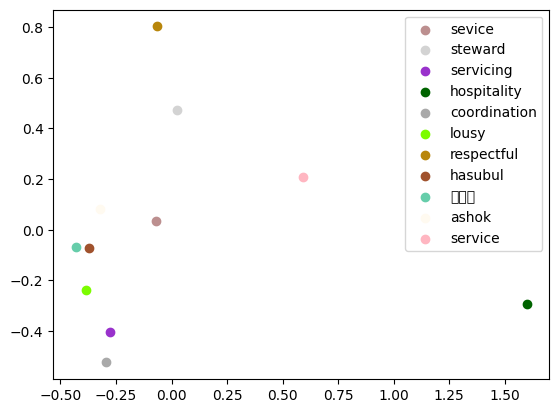

In [240]:
fig, ax = plt.subplots()
colors = mcolors.CSS4_COLORS
colors_ = random.choices(list(mcolors.CSS4_COLORS.keys()), k=11)

for i, coord in enumerate(pca_result):
    ax.scatter(coord[0], coord[1], c=colors_[i], label= similar_w_[i])
ax.legend()
plt.show()

In [241]:
vecs2 = []
similar_w2 = []
for w in models[idx].wv.most_similar('place', topn=10):
    similar_w2.append(w)

In [243]:
word_vectors2 = [models[idx].wv[w[0]] for w in similar_w2]
word_vectors2.append(models[idx].wv['place'])

In [244]:
pca_result2 = pca.fit_transform(word_vectors2)

In [245]:
similar_w_2 = [w[0] for w in similar_w2]
similar_w_2.append('place')

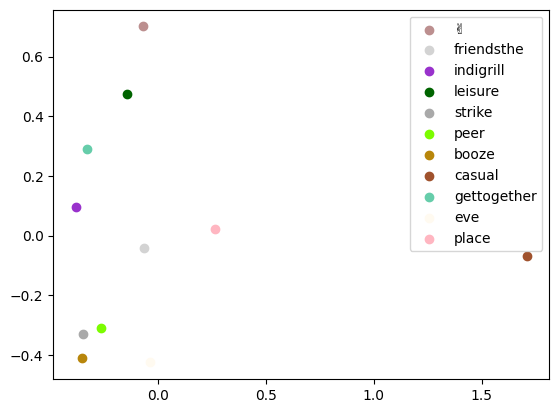

In [246]:
fig, ax = plt.subplots()
for i, coord in enumerate(pca_result2):
    ax.scatter(coord[0], coord[1], c=colors_[i], label= similar_w_2[i])
ax.legend()
plt.show()

CBOW и SKIPgram

Skip-Gram хорошо работает с небольшими наборами данных и может лучше представлять менее частые слова.
CBOW обучается быстрее, чем Skip-Gram, и может лучше представлять более частые слова.

Задачи семантичского поиска